In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
from numpy.polynomial.hermite import hermval
x = np.arange(-6, 6, 0.1)
h0 = hermval(x, [1, 0, 0])
h1 = hermval(x, [0, 1, 0])
h2 = hermval(x, [0, 0, 1])/10
#plt.plot(x, h0)
#plt.plot(x, h1)
#plt.plot(x, h2)

In [3]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

gh0 = gaussian(x) * h0
gh1 = gaussian(x) * h1
gh2 = gaussian(x) * h2
#plt.plot(x, gh0)
#plt.plot(x, gh1)
#plt.plot(x, gh2)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

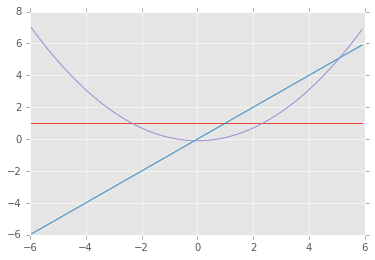

In [4]:
from numpy.polynomial.chebyshev import chebval
h0 = chebval(x, [1, 0, 0])
h1 = chebval(x, [0, 1, 0])
h2 = chebval(x, [0, 0, 1])/10
plt.plot(x, h0)
plt.plot(x, h1)
plt.plot(x, h2)

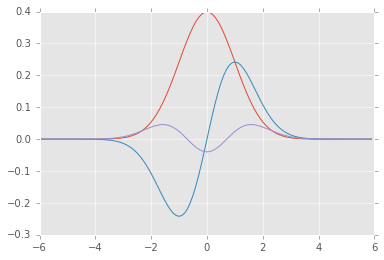

In [5]:
gh0 = gaussian(x) * h0
gh1 = gaussian(x) * h1
gh2 = gaussian(x) * h2
plt.plot(x, gh0)
plt.plot(x, gh1)
plt.plot(x, gh2)

## Generate AL basis funcs now...

use same parameters as from the stack.

In [18]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 2   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
spatialKernelOrder = 1
spatialBackgroundOrder = 1
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebBasis(x, ord):
    coef = np.zeros(ord+1)
    coef[-1] = 1
    ch = chebval(x, coef)
    return ch, coef

def chebGauss(x, m=0., s=1., ord=0, beta=1., kernelOrd=0):
    ga = gaussian(x, m, s/beta)
    ch, coef = chebBasis(x, ord)
    print s, ord, kernelOrd, coef
    return ga * ch * x**kernelOrd

0.75 0 0 [ 1.]
0.75 0 1 [ 1.]
0.75 1 0 [ 0.  1.]
0.75 1 1 [ 0.  1.]
0.75 2 0 [ 0.  0.  1.]
0.75 2 1 [ 0.  0.  1.]
0.75 3 0 [ 0.  0.  0.  1.]
0.75 3 1 [ 0.  0.  0.  1.]
1.5 0 0 [ 1.]
1.5 0 1 [ 1.]
1.5 1 0 [ 0.  1.]
1.5 1 1 [ 0.  1.]
3.0 0 0 [ 1.]
3.0 0 1 [ 1.]
3.0 1 0 [ 0.  1.]
3.0 1 1 [ 0.  1.]


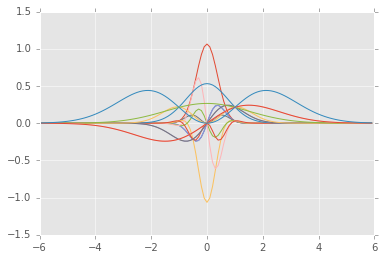

In [38]:
basis = [chebGauss(x, m=0, s=sig, ord=deg, beta=betaGauss, kernelOrd=ko) \
         for i,sig in enumerate(sigGauss) for deg in range(degGauss[i]) for ko in range(spatialKernelOrder+1)]
basis = np.vstack(basis).T  # put the bases into columns
# basis = pd.DataFrame(basis); basis.plot()
for b in basis.T:
    plt.plot(x, b)

Make the two "images". `im1` is the template, `im2` is the science image.

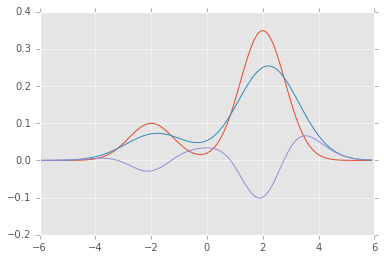

In [39]:
im1 = 0.2 * gaussian(x, m=-2.0, s=0.8) + 0.7 * gaussian(x, m=2.0, s=0.8)  # template
im2 = 0.2 * gaussian(x, m=-1.8, s=1.1) + 0.7 * gaussian(x, m=2.2, s=1.1)  # science image; include a slight registration error
plt.plot(x, im1); plt.plot(x, im2); plt.plot(x, im2-im1)

Convolve im2 with the basis functions, and make these the *new* bases.

In [40]:
# Single call to do it with all bases
basis2 = [np.convolve(im1, b, mode='same') - im1 for b in basis.T]
basis2 = np.vstack(basis2).T 
print basis2.shape
bgBasis = [chebBasis(x, ord)[0] for ord in range(spatialBackgroundOrder+1)]
bgBasis = np.vstack(bgBasis).T
basis2 = np.hstack([basis2, bgBasis])
print basis2.shape

(120, 16)
(120, 18)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

Here we are plotting the resulting fitted diffim (red) vs. the actual diffim (blue)

[ -3.78119913e-02  -7.11681837e-04  -7.11681837e-04  -3.17408580e-02
  -2.56697247e-02  -3.23319929e-04   6.50419789e-05  -3.13879021e-02
   1.20425164e-01   8.95712247e-03   8.95712247e-03  -5.84381198e-03
   1.84244940e-03   2.25972697e-05   2.25972698e-05  -1.48159036e-04
   2.06838496e-06  -6.73241248e-07]
(120, 18) (120,)


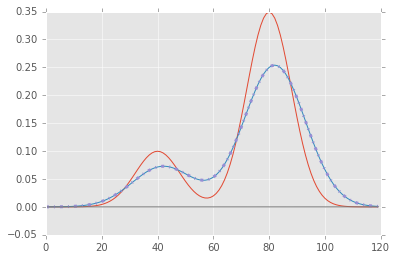

In [41]:
pars = np.linalg.lstsq(basis2, im2)[0]
print pars
fit = (pars * basis2).sum(1)
print basis2.shape, fit.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(im1)  # original template (red)
plt.plot(fit)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - fit)  # diffim (grey)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(-2, 2)

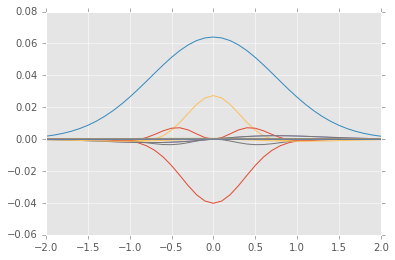

In [46]:
# First let's plot the bases times their coefficients
fit = pars[:-2] * basis
for f in fit.T:
    plt.plot(x, f)
plt.xlim(-2, 2)

(-3, 3)

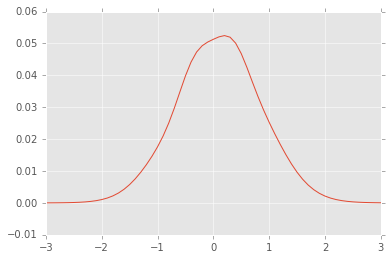

In [49]:
fit = (pars[:-2] * basis).sum(1)
fit /= fit.sum()
plt.plot(x, fit)  # this plots the matching kernel
plt.xlim(-3, 3)

Compare the convolved template to the science image. Also plot the new diffim for comparison.

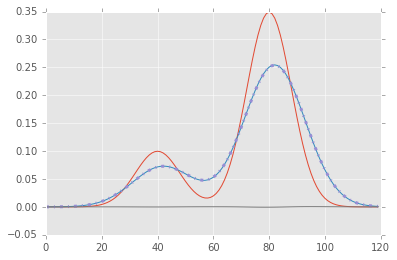

In [50]:
conv_im1 = np.convolve(im1, fit, mode='same')
plt.plot(im1)  # original template (red)
plt.plot(conv_im1)  # convolved template (blue)
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - conv_im1)  # diffim (grey)

OK, this is probably overfitting - hence the need for either parameter selection (via BIC?) or PCA.